# Zadanie 16

In [ ]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import plotly.express as px
import matplotlib.pyplot as plt

# 1. WCZYTANIE DANYCH
df = pd.read_csv('FakeJobs/fake_real_job_postings_3000x25.csv')

analysis_df = df.copy()

# 2. PRZETWARZANIE KOLUMN (PREPROCESSING)

# A. Mapowanie celu (is_fake) na czytelne etykiety
analysis_df['is_fake'] = analysis_df['is_fake'].map({1: 'Status:Fake', 0: 'Status:Real', '1': 'Status:Fake', '0': 'Status:Real'})

# B. Mapowanie zmiennych binarnych (has_logo, telecommuting)
analysis_df['has_logo'] = analysis_df['has_logo'].map({1: 'Logo:Yes', 0: 'Logo:No', '1': 'Logo:Yes', '0': 'Logo:No'})
analysis_df['telecommuting'] = analysis_df['telecommuting'].map({1: 'Remote:Yes', 0: 'Remote:No', '1': 'Remote:Yes', '0': 'Remote:No'})

# C. Dyskretyzacja długości tekstu (text_length)
analysis_df['Desc_Length'] = pd.cut(
    analysis_df['text_length'], 
    bins=3, 
    labels=['Len:Short', 'Len:Medium', 'Len:Long']
)

# D. Wybór kolumn do analizy
cols_to_use = [
    'is_fake', 
    'industry', 
    'employment_type', 
    'required_experience_years', 
    'education_level', 
    'job_function',
    'has_logo',
    'telecommuting',
    'Desc_Length',
    'location',
    'salary_range',
    'department',
    'posting_date',
    'application_deadline',
    'num_open_positions'
]

# Tworzymy podzbiór danych
analysis_df = analysis_df[cols_to_use].copy()

# Konwertujemy kolumny typu 'category' (np. Desc_Length) na zwykłe obiekty,
# aby móc wpisać tam dowolny tekst (np. 'Unknown').
for col in analysis_df.columns:
    if analysis_df[col].dtype.name == 'category':
        analysis_df[col] = analysis_df[col].astype('object')
        
# Teraz fillna zadziała bez błędu, bo nie ma już restrykcji kategorii
analysis_df.fillna('Unknown', inplace=True)

# Konwersja wszystkiego na string (dla pewności przed algorytmem Apriori)
for col in analysis_df.columns:
    analysis_df[col] = analysis_df[col].astype(str)

# 3. PRZYGOTOWANIE TRANSAKCJI DLA APRIORI
dataset = []
for index, row in analysis_df.iterrows():
    transaction = []
    for col in analysis_df.columns:
        val = row[col]
        # Pomijamy 'Unknown' żeby nie zaciemniać reguł
        if val != 'Unknown':
            # Jeśli kolumna to nie jest jedna z tych, które już mają prefiks (jak Status:Fake)
            if col not in ['is_fake', 'has_logo', 'telecommuting', 'Desc_Length']:
                transaction.append(f"{col}={val}")
            else:
                transaction.append(val)
    dataset.append(transaction)

# One-Hot Encoding
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Przygotowano {len(df_trans)} transakcji.")

# 4. GENEROWANIE REGUŁ
min_support = 0.16  # Lower if want more rules
min_confidence = 0.8

frequent_itemsets = apriori(df_trans, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

# 5. FILTROWANIE REGUŁ PROWADZĄCYCH DO 'FAKE'
print("Top reguły wskazujące na fałszywe ogłoszenia:")
fake_rules = rules[
    rules['consequents'].apply(lambda x: 'Status:Fake' in list(x))
]

if not fake_rules.empty:
    display(fake_rules.sort_values(by='lift', ascending=False).head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
else:
    print("Nie znaleziono silnych reguł dla 'Status:Fake' przy obecnych progach. Spróbuj zmniejszyć min_support.")

# 6. WIZUALIZACJA
# Przygotowanie danych string dla wykresu
rules['antecedent_str'] = rules['antecedents'].apply(lambda x: list(x)[0])
rules['consequent_str'] = rules['consequents'].apply(lambda x: list(x)[0])

fig = px.parallel_categories(
    rules.sort_values('confidence', ascending=False).head(50),
    dimensions=['antecedent_str', 'consequent_str'],
    color="lift",
    title="Przepływ Reguł Asocjacyjnych"
)
fig.show()

Przygotowano 3000 transakcji.
Top reguły wskazujące na fałszywe ogłoszenia:


,antecedents,consequents,support,confidence,lift
5,(Len:Short),(Status:Fake),0.490667,1.0,2.038043
21,"(Len:Short, Logo:No)",(Status:Fake),0.490667,1.0,2.038043
23,(Len:Short),"(Status:Fake, Logo:No)",0.490667,1.0,2.038043
25,"(Remote:No, Len:Short)",(Status:Fake),0.236333,1.0,2.038043
27,"(Remote:Yes, Len:Short)",(Status:Fake),0.254333,1.0,2.038043
32,"(Len:Short, Remote:No, Logo:No)",(Status:Fake),0.236333,1.0,2.038043
34,"(Remote:No, Len:Short)","(Status:Fake, Logo:No)",0.236333,1.0,2.038043
37,"(Remote:Yes, Len:Short, Logo:No)",(Status:Fake),0.254333,1.0,2.038043
39,"(Remote:Yes, Len:Short)","(Status:Fake, Logo:No)",0.254333,1.0,2.038043



--- Rozpoczynam analizę zależności od Support Min ---
Support: 0.1    | Czas: 0.0632s | Częste: 340   | Max Rozmiar: 4
Support: 0.15   | Czas: 0.0159s | Częste: 92    | Max Rozmiar: 4
Support: 0.2    | Czas: 0.0084s | Częste: 60    | Max Rozmiar: 4
Support: 0.3    | Czas: 0.0060s | Częste: 14    | Max Rozmiar: 3
Support: 0.4    | Czas: 0.0053s | Częste: 12    | Max Rozmiar: 3


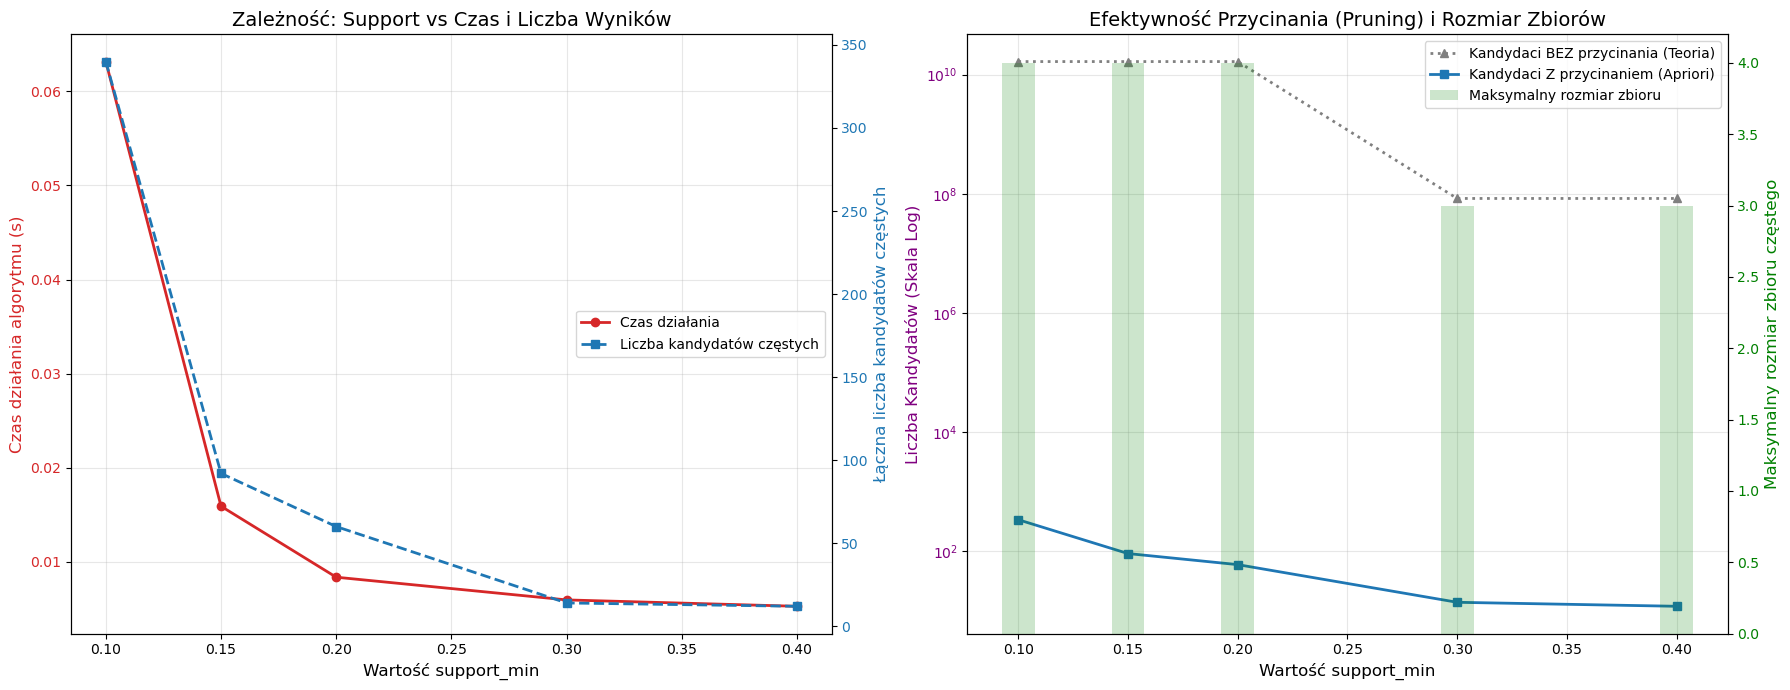

In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from mlxtend.frequent_patterns import apriori

# ==========================================
# 7. (Zadanie 16c) ANALIZA WYDAJNOŚCI
# ==========================================

print("\n--- Rozpoczynam analizę zależności od Support Min ---")

# 1. ZMIANA: Podnosimy progi, aby uniknąć MemoryError.
# Zamiast od 0.01, zaczynamy od 0.05 lub 0.1.
supports = [0.1, 0.15, 0.2, 0.3, 0.4]

times = []
frequent_counts = []      # Zbiory częste (z przycinaniem)
theoretical_counts = []   # Teoretyczne (bez przycinania)
max_sizes = []

# Liczba kolumn (cech) w one-hot encoded dataset
n_features = df_trans.shape[1]

for s in supports:
    # --- Pomiar czasu ---
    start_time = time.time()
    # Można użyć low_memory=True
    try:
        fi = apriori(df_trans, min_support=s, use_colnames=True)
    except MemoryError:
        print(f"Błąd pamięci dla supportu {s}. Pomijam tę wartość.")
        continue
        
    end_time = time.time()
    
    # Zbieranie danych
    duration = end_time - start_time
    count = len(fi)
    
    if count > 0:
        max_sz = fi['itemsets'].apply(len).max()
    else:
        max_sz = 0
    


    # --- Obliczenia Teoretyczne (Brute Force) ---
    theoretical_candidates = 0
    if max_sz > 0:
        for k in range(1, max_sz + 1):
            theoretical_candidates += comb(n_features, k, exact=False)
            
    # Zapisujemy wyniki
    times.append(duration)
    frequent_counts.append(count)
    max_sizes.append(max_sz)
    theoretical_counts.append(theoretical_candidates)
    
    print(f"Support: {s:<6} | Czas: {duration:.4f}s | Częste: {count:<5} | Max Rozmiar: {max_sz}")

# ==========================================
# WIZUALIZACJA 
# ==========================================
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(18, 7))

# --- WYKRES 1: Czas i Liczba Kandydatów Częstych ---

# Oś Y1: Czas
ax1.set_xlabel('Wartość support_min', fontsize=12)
ax1.set_ylabel('Czas działania algorytmu (s)', color='tab:red', fontsize=12)
line1 = ax1.plot(supports, times, marker='o', color='tab:red', linewidth=2, label='Czas działania')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Oś Y2: Liczba Kandydatów Częstych
ax2 = ax1.twinx()
ax2.set_ylabel('Łączna liczba kandydatów częstych', color='tab:blue', fontsize=12)
line2 = ax2.plot(supports, frequent_counts, marker='s', linestyle='--', color='tab:blue', linewidth=2, label='Liczba kandydatów częstych')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Tytuł i Legenda
ax1.set_title('Zależność: Support vs Czas i Liczba Wyników', fontsize=14)
ax1.grid(True, alpha=0.3)

# Połączona legenda dla obu osi
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')


# --- WYKRES 2: Efekt Przycinania i Max Rozmiar ---

# Oś Y1: Porównanie Kandydatów (Skala Logarytmiczna)
ax3.set_xlabel('Wartość support_min', fontsize=12)
ax3.set_ylabel('Liczba Kandydatów (Skala Log)', color='purple', fontsize=12)
ax3.set_yscale('log') 

# Linia 1: Bez przycinania (Teoria)
line3 = ax3.plot(supports, theoretical_counts, marker='^', color='gray', linestyle=':', linewidth=2, label='Kandydaci BEZ przycinania (Teoria)')

# Linia 2: Z przycinaniem (Faktyczne obliczenia)
line4 = ax3.plot(supports, frequent_counts, marker='s', color='tab:blue', linewidth=2, label='Kandydaci Z przycinaniem (Apriori)')

ax3.tick_params(axis='y', labelcolor='purple')

# Oś Y2: Maksymalny rozmiar zbioru
ax4 = ax3.twinx()
ax4.set_ylabel('Maksymalny rozmiar zbioru częstego', color='green', fontsize=12)
bar1 = ax4.bar(supports, max_sizes, width=0.015, color='green', alpha=0.2, label='Maksymalny rozmiar zbioru')
ax4.tick_params(axis='y', labelcolor='green')

# Tytuł i Legenda
ax3.set_title('Efektywność Przycinania (Pruning) i Rozmiar Zbiorów', fontsize=14)
ax3.grid(True, alpha=0.3)

lines_right = line3 + line4 + [bar1]
labels_right = [l.get_label() for l in lines_right]
ax3.legend(lines_right, labels_right, loc='upper right')

plt.tight_layout()
plt.show()

Data set z używaniem AI

In [ ]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import plotly.express as px
import time

# ==========================================
# 1. PRZYGOTOWANIE DANYCH 
# ==========================================

# Wczytujemy dane
filename = 'AIUsage/ai_impact_student_performance_dataset.csv'
df = pd.read_csv(filename)

# Tworzymy kopię do analizy
analysis_df = df.copy()

# A. Mapowanie zmiennych binarnych i tekstowych na czytelne etykiety
# Zakładam, że uses_ai to 1/0 lub True/False
if 'uses_ai' in analysis_df.columns:
    analysis_df['uses_ai'] = analysis_df['uses_ai'].apply(lambda x: 'AI_User:Yes' if (x==1 or x=='Yes' or x==True) else 'AI_User:No')

if 'passed' in analysis_df.columns:
    analysis_df['passed'] = analysis_df['passed'].apply(lambda x: 'Result:Pass' if (x==1 or x=='Yes' or x==True) else 'Result:Fail')

if 'gender' in analysis_df.columns:
    analysis_df['gender'] = 'Gender:' + analysis_df['gender'].astype(str)

# B. Dyskretyzacja (Binning)

# 1. FINAL SCORE (0-100) -> Zamieniamy na kategorie
# Dzielimy: 0-60 (Low), 60-85 (Avg), 85-100 (High)
if 'final_score' in analysis_df.columns:
    analysis_df['Score_Group'] = pd.cut(
        analysis_df['final_score'], 
        bins=[-1, 60, 85, 100], 
        labels=['Score:Low', 'Score:Avg', 'Score:High']
    )

# 2. AI DEPENDENCY (Zależność od AI)
# Jeśli to skala np. 0-5 lub 0-10, dzielimy na Low/High
if 'ai_dependency_score' in analysis_df.columns:
    # Używamy qcut, żeby podzielić na 3 równe liczebnie grupy
    analysis_df['AI_Dependency'] = pd.qcut(
        analysis_df['ai_dependency_score'], 
        q=3, 
        labels=['AIDep:Low', 'AIDep:Medium', 'AIDep:High']
    )

# 3. STUDY HOURS
if 'study_hours_per_day' in analysis_df.columns:
    analysis_df['Study_Time'] = pd.cut(
        analysis_df['study_hours_per_day'],
        bins=[-1, 2, 5, 24],
        labels=['Study:Low', 'Study:Medium', 'Study:High']
    )

# Dodajemy prefix do oryginalnej kategorii performance, żeby nie myliła się z innymi
if 'performance_category' in analysis_df.columns:
    analysis_df['performance_category'] = analysis_df['performance_category'].apply(lambda x: f"Perf:{x}")
    
# C. Wybór kolumn do analizy
# Wybieramy te, które przerobiliśmy na kategorie + te, które już były kategoriami
cols_to_use = [
    'Score_Group',      # Nasz cel
    'passed',           # Czy zdał
    'uses_ai',          # Czy używa AI
    'AI_Dependency',    # Jak bardzo polega na AI
    'Study_Time',       # Ile się uczy
    'gender',
    'performance_category' 
]

# Filtrujemy tylko istniejące kolumny
cols_to_use = [c for c in cols_to_use if c in analysis_df.columns]
analysis_df = analysis_df[cols_to_use].copy()

# Konwersja wszystkiego na string
analysis_df = analysis_df.astype(str)

# D. One-Hot Encoding
dataset = analysis_df.values.tolist()
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Przygotowano {len(df_trans)} transakcji. Przykładowe kolumny: {list(df_trans.columns)[:5]}")

# ==========================================
# 2. GENEROWANIE REGUŁ
# ==========================================

# Ustawiamy łagodne progi, żeby coś znaleźć
min_support = 0.05      # Min 5% wystąpień
min_confidence = 0.8    # Min 80% pewności

frequent_itemsets = apriori(df_trans, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

print(f"\nZnaleziono {len(rules)} reguł.")

# ==========================================
# 3. WYNIKI DLA 'HIGH SCORE'
# ==========================================

# Szukamy reguł, które prowadzą do wysokiego wyniku (Score:High)
target_string = 'Score:High'

target_rules = rules[
    rules['consequents'].apply(lambda x: target_string in str(list(x)))
]

if not target_rules.empty:
    print(f"\n--- TOP Reguły prowadzące do {target_string} ---")
    display(target_rules.sort_values(by='lift', ascending=False).head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
else:
    print(f"\nBrak silnych reguł dla '{target_string}'. Sprawdzam 'Score:Low'...")
    # Alternatywnie sprawdzamy co prowadzi do niskich wyników
    bad_rules = rules[rules['consequents'].apply(lambda x: 'Score:Low' in str(list(x)))]
    if not bad_rules.empty:
        display(bad_rules.sort_values(by='lift', ascending=False).head(5))

# ==========================================
# 4. WIZUALIZACJA
# ==========================================
if not rules.empty:
    # Przygotowanie stringów
    rules['antecedent_str'] = rules['antecedents'].apply(lambda x: list(x)[0])
    rules['consequent_str'] = rules['consequents'].apply(lambda x: list(x)[0])

    # Wybieramy najciekawsze reguły
    top_viz_rules = rules.sort_values(by='lift', ascending=False).head(40)

    fig = px.parallel_categories(
        top_viz_rules,
        dimensions=['antecedent_str', 'consequent_str'],
        color="lift",
        color_continuous_scale=px.colors.sequential.Inferno,
        title="Przepływ reguł: Co wpływa na wyniki studentów?"
    )
    fig.show()

Przygotowano 8000 transakcji. Przykładowe kolumny: ['AIDep:High', 'AIDep:Low', 'AIDep:Medium', 'AI_User:No', 'AI_User:Yes']

Znaleziono 388 reguł.

Brak silnych reguł dla 'Score:High'. Sprawdzam 'Score:Low'...


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
265,"(Result:Fail, Gender:Male)","(Score:Low, Perf:Low)",0.05600,0.317750,0.05600,1.0,3.147128,1.0,0.038206,inf,0.722722,0.176239,1.0,0.588120
236,"(Result:Fail, AI_User:Yes)","(Score:Low, Perf:Low)",0.07025,0.317750,0.07025,1.0,3.147128,1.0,0.047928,inf,0.733799,0.221086,1.0,0.610543
282,"(Result:Fail, Study:Medium)","(Score:Low, Perf:Low)",0.06050,0.317750,0.06050,1.0,3.147128,1.0,0.041276,inf,0.726184,0.190401,1.0,0.595201
95,(Result:Fail),"(Score:Low, Perf:Low)",0.11075,0.317750,0.11075,1.0,3.147128,1.0,0.075559,inf,0.767220,0.348544,1.0,0.674272
10,(Perf:Low),(Score:Low),0.31775,0.589375,0.31775,1.0,1.696713,1.0,0.130476,inf,0.601869,0.539130,1.0,0.769565


# Zadanie 17 

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.ensemble import IsolationForest
from scipy.cluster.hierarchy import dendrogram, linkage
from mlxtend.preprocessing import TransactionEncoder


df = pd.read_csv('FakeJobs/fake_real_job_postings_3000x25.csv') 

data = df.copy()

# 2. Wybór cech do klastryzacji
features = [
    'telecommuting', 
    'has_logo',                  
    'employment_type', 
    'required_experience_years', 
    'education_level',           
    'industry', 
    'job_function'               
]

labels_true = data['is_fake']

# 3. Preprocessing
# Wypełnianie braków w cechach
X = data[features].fillna('Unknown')

# Zamiana zmiennych kategorialnych na liczbowe (One-Hot Encoding)
# drop_first=True usuwa nadmiarowość (np. jeśli nie jest A i nie B, to musi być C)
X_encoded = pd.get_dummies(X, drop_first=True)

# 4. Skalowanie danych (Kluczowe dla K-Means i PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

print(f"Dane gotowe. Wymiary macierzy: {X_scaled.shape}")
print(f"Liczba etykiet 'fake' w zbiorze: {sum(labels_true == 1)}")

Dane gotowe. Wymiary macierzy: (3000, 18)
Liczba etykiet 'fake' w zbiorze: 1472


k     Inertia         Purity     Anomalies in Cluster 0 (przykładowo)
------------------------------------------------------------
2     50307.40        0.5093     60/782
3     46973.53        0.5093     72/1780
4     43811.70        0.5110     28/519
5     40788.87        0.5110     28/1049
6     38950.70        0.5110     28/519
7     38529.33        0.5093     27/483
8     37221.40        0.5093     26/414
9     36597.80        0.5100     16/375
10    35987.59        0.5140     8/157


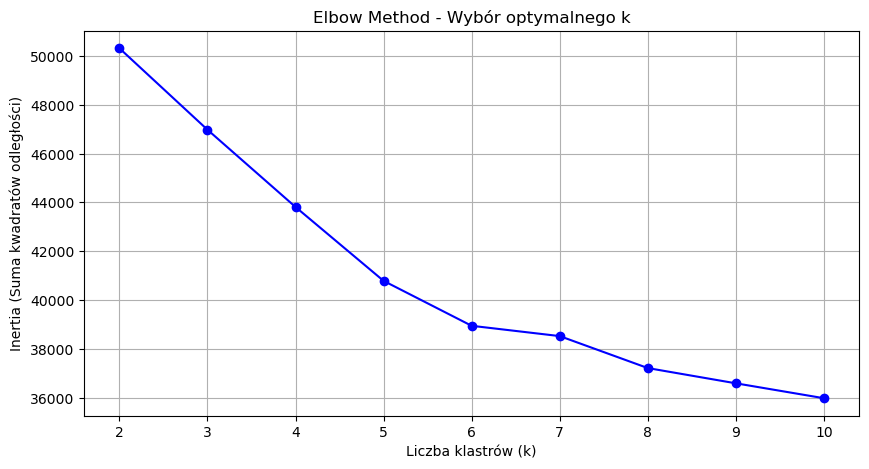

In [31]:
def purity_score(y_true, y_pred):
    # Oblicza "czystość" klastrów względem prawdziwych etykiet
    contingency_matrix = confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# 1. Wykrywanie anomalii (niezależnie od klastrów)
# Zakładamy, że około 5% danych to anomalie (tyle mniej więcej jest fake jobs)
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomalies = iso_forest.fit_predict(X_scaled)
# -1 to anomalia, 1 to normalny. Zamieniamy na: 1 (anomalia), 0 (norma)
anomalies_binary = [1 if x == -1 else 0 for x in anomalies]

# 2. Pętla po k (liczba klastrów)
inertia = []
purities = []
k_values = range(2, 11)

print(f"{'k':<5} {'Inertia':<15} {'Purity':<10} {'Anomalies in Cluster 0 (przykładowo)'}")
print("-" * 60)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Metryki
    inertia.append(kmeans.inertia_)
    purity = purity_score(labels_true, clusters)
    purities.append(purity)
    
    # Analiza anomalii w klastrach
    df_temp = pd.DataFrame({'cluster': clusters, 'anomaly': anomalies_binary, 'label': labels_true})
    # Sprawdzamy, czy anomalie skupiają się w konkretnych klastrach
    anomalies_per_cluster = df_temp.groupby('cluster')['anomaly'].sum()
    
    print(f"{k:<5} {kmeans.inertia_:<15.2f} {purity:<10.4f} {anomalies_per_cluster.iloc[0]}/{len(df_temp[df_temp['cluster']==0])}")

# 3. Wykres Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Inertia (Suma kwadratów odległości)')
plt.title('Elbow Method - Wybór optymalnego k')
plt.grid(True)
plt.show()

# Wnioski
optimal_k = 6 # (Wartość odczytana z wykresu, np. gdzie wykres się "łamie")

Wariancja wyjaśniona przez 2 komponenty PCA: 15.32%


,Dane,Silhouette,Purity
0,Oryginalne,0.072764,0.509333
1,PCA (2D),0.369322,0.514000


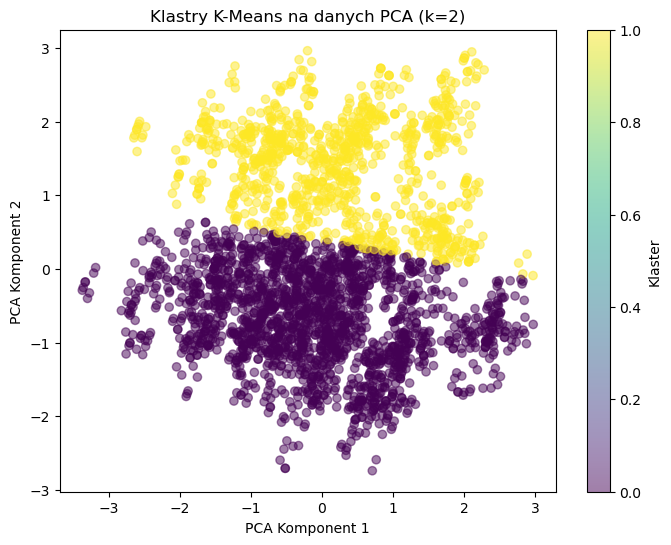

In [32]:
from sklearn.metrics import silhouette_score

# 1. Redukcja wymiarowości (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Wariancja wyjaśniona przez 2 komponenty PCA: {sum(pca.explained_variance_ratio_):.2%}")

# 2. Porównanie dla wybranego k 
k_comp = 2 # Sprawdźmy czy algorytm rozdzieli Fake od Real (k=2)

results = []

for name, data_in in [("Oryginalne", X_scaled), ("PCA (2D)", X_pca)]:
    km = KMeans(n_clusters=k_comp, random_state=42, n_init=10)
    labels_pred = km.fit_predict(data_in)
    
    sil = silhouette_score(data_in, labels_pred)
    pur = purity_score(labels_true, labels_pred)
    
    results.append({'Dane': name, 'Silhouette': sil, 'Purity': pur})

results_df = pd.DataFrame(results)
display(results_df)

# Wizualizacja klastrów w PCA
plt.figure(figsize=(8, 6))
km_pca = KMeans(n_clusters=k_comp, random_state=42, n_init=10)
labels_pca = km_pca.fit_predict(X_pca)

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pca, cmap='viridis', alpha=0.5)
plt.title(f'Klastry K-Means na danych PCA (k={k_comp})')
plt.xlabel('PCA Komponent 1')
plt.ylabel('PCA Komponent 2')
plt.colorbar(scatter, label='Klaster')
plt.show()

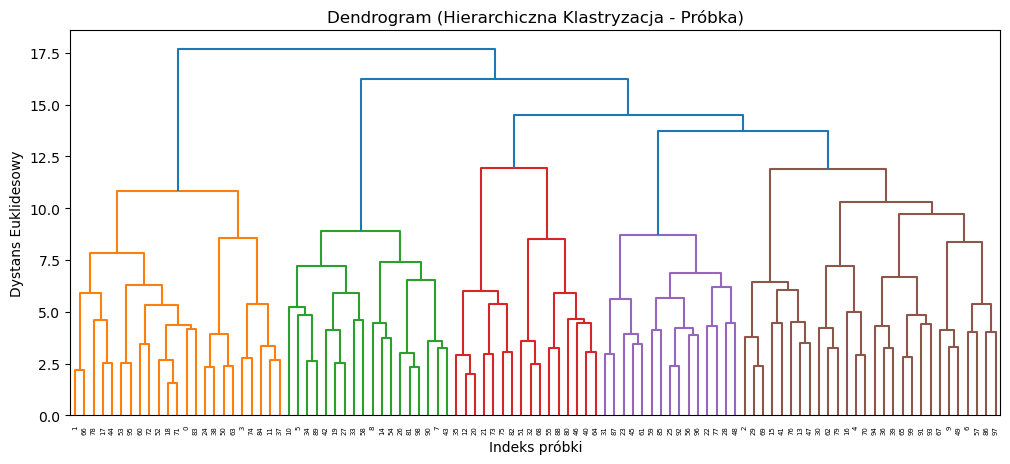

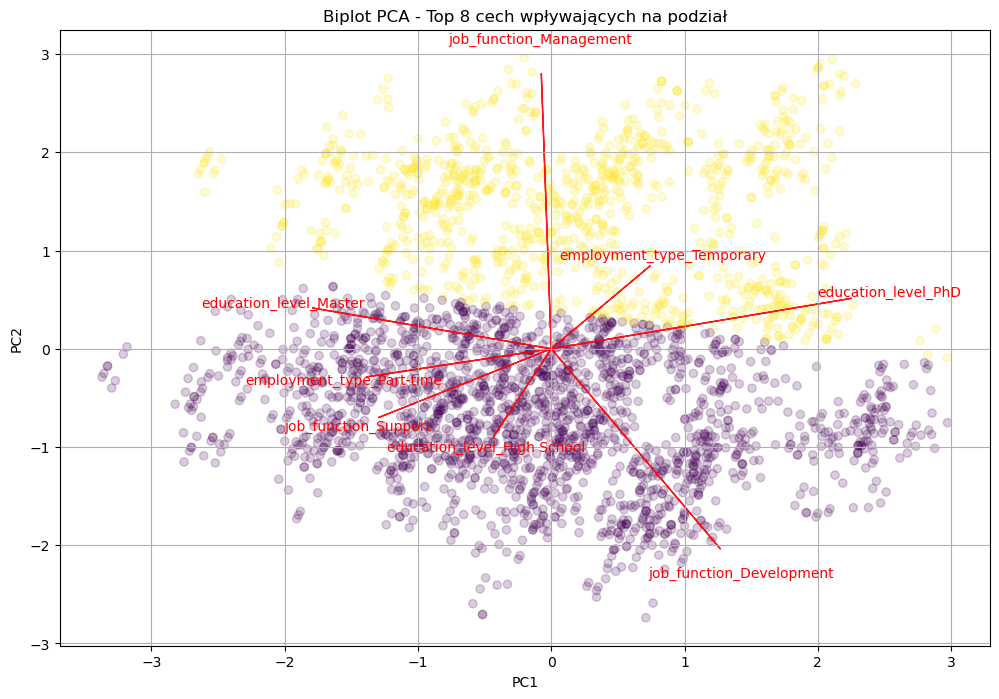

In [33]:
# --- 1. Dendrogram (Mapa ciepła hierarchii) ---
# Bierzemy próbkę losową 100 obserwacji dla czytelności
sample_idx = np.random.choice(len(X_scaled), 100, replace=False)
X_sample = X_scaled[sample_idx]

plt.figure(figsize=(12, 5))
plt.title("Dendrogram (Hierarchiczna Klastryzacja - Próbka)")
dendrogram(linkage(X_sample, method='ward'))
plt.xlabel("Indeks próbki")
plt.ylabel("Dystans Euklidesowy")
plt.show()

# --- 2. PCA Biplot (Analiza cech) ---
# Funkcja do rysowania wektorów cech na wykresie PCA
def biplot(score, coeff, labels=None, top_n=5):
    plt.figure(figsize=(12, 8))
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    
    # Rysujemy punkty (obserwacje)
    plt.scatter(xs, ys, c=labels_pca, cmap='viridis', alpha=0.2)
    
    # Wybieramy TOP N cech o największym wpływie na PCA
    # (liczymy długość wektora)
    feature_magnitude = np.sqrt(coeff[:,0]**2 + coeff[:,1]**2)
    top_indices = np.argsort(feature_magnitude)[-top_n:]
    
    # Rysujemy wektory (strzałki)
    for i in top_indices:
        plt.arrow(0, 0, coeff[i,0]*4, coeff[i,1]*4, color='r', alpha=0.9)
        plt.text(coeff[i,0]*4.5, coeff[i,1]*4.5, labels[i], color='r', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Biplot PCA - Top {top_n} cech wpływających na podział")
    plt.grid()

# Pobranie nazw cech po One-Hot Encoding
feature_names = X_encoded.columns

# Rysowanie biplotu
biplot(X_pca, pca.components_.T, labels=feature_names, top_n=8)
plt.show()

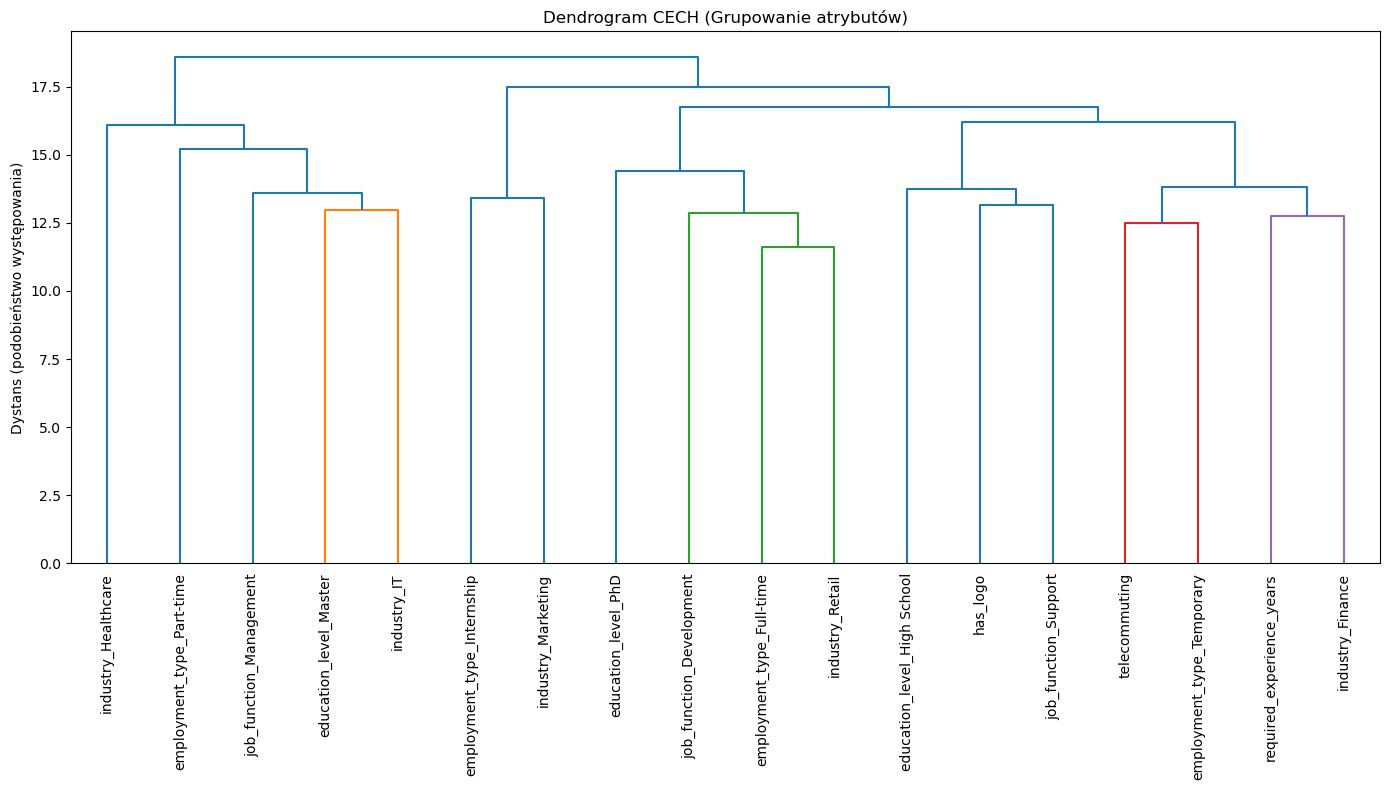

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# 1. Pobieramy nazwy cech z oryginalnego DataFrame (przed skalowaniem/konwersją na numpy)

feature_names = X_encoded.columns.tolist() 

# 2. Obliczamy macierz powiązań (Linkage) na transponowanej macierzy (.T)
Z = linkage(X_sample.T, method='ward')

# 3. Rysujemy
plt.figure(figsize=(14, 8))
plt.title("Dendrogram CECH (Grupowanie atrybutów)")

dendrogram(
    Z,
    labels=feature_names,    
    leaf_rotation=90,         # Obracamy napisy pionowo
    leaf_font_size=10
)

plt.ylabel("Dystans (podobieństwo występowania)")
plt.tight_layout()
plt.show()

Generowanie opisanej mapy ciepła...


/home/bartek/anaconda3/envs/kombi/lib/python3.11/site-packages/seaborn/matrix.py:495: DeprecationWarning:

`product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.

/home/bartek/anaconda3/envs/kombi/lib/python3.11/site-packages/seaborn/matrix.py:495: DeprecationWarning:

`product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.



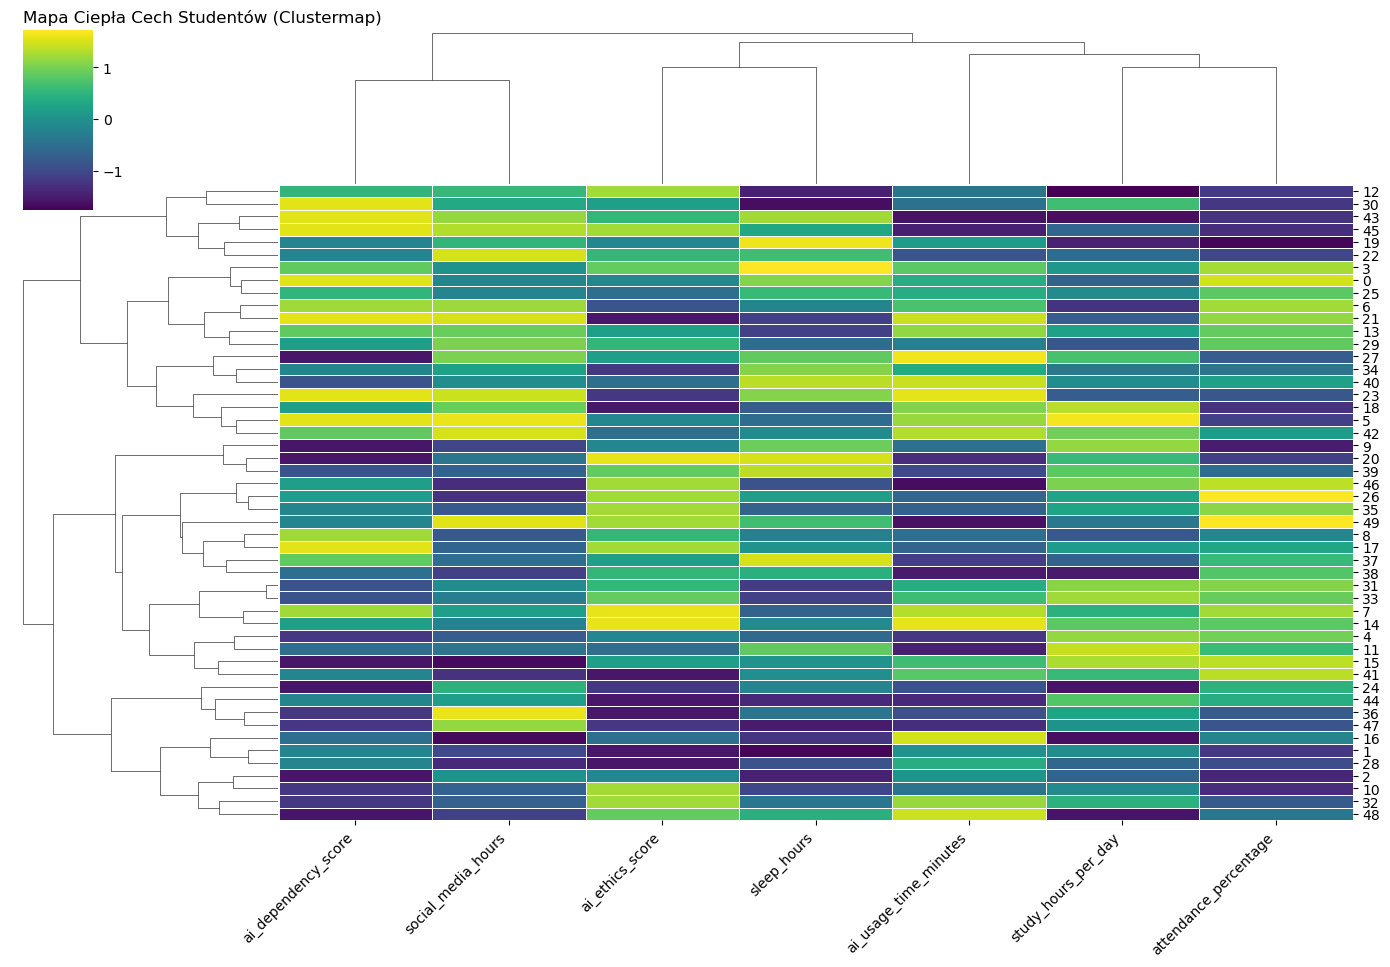

In [40]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# POPRAWKA: Przywracanie nazw kolumn
# ==========================================

# 1. Upewnij się, że masz listę nazw cech z wcześniejszego etapu kodu
# W kodzie dla studentów ta zmienna nazywała się 'available_features'
# Jeśli jej nie masz pod ręką, odtwórz ją ręcznie:
if 'available_features' not in locals():
    available_features = [
        'study_hours_per_day', 'ai_usage_time_minutes', 'ai_dependency_score', 
        'ai_ethics_score', 'attendance_percentage', 'sleep_hours', 'social_media_hours'
    ]

# 2. Zamiana macierzy NumPy (X_sample) na DataFrame z nazwami
# Dzięki temu na osi X pojawią się napisy zamiast liczb 0, 1, 2...
df_plot = pd.DataFrame(X_sample, columns=available_features)

# ==========================================
# RYSOWANIE MAPY CIEPŁA
# ==========================================

print("Generowanie opisanej mapy ciepła...")

g = sns.clustermap(
    df_plot,               # Podajemy DataFrame z nazwami!
    method='ward',         # Metoda łączenia klastrów
    metric='euclidean',    # Metoda liczenia odległości
    cmap='viridis',        # Kolory: Fioletowy (niska wartość) -> Żółty (wysoka)
    figsize=(14, 10),      
    dendrogram_ratio=0.2,  # Proporcja wielkości drzewka do mapy
    linewidths=0.5,        # Linie oddzielające kratki
    xticklabels=True,      # Pokaż nazwy cech na dole (Teraz zadziała!)
    yticklabels=True       # Pokaż numery studentów po prawej
)

# Opcjonalnie: Obrót napisów na dole, żeby były czytelne
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')

plt.title("Mapa Ciepła Cech Studentów (Clustermap)", loc='left')
plt.show()

Dane przygotowane do klastryzacji. Wymiary: (3000, 18)

k     Inertia         Purity (Zgodność z etykietami)
------------------------------------------------------------
2     50307.40        0.5093    
3     46973.53        0.5093    
4     43811.70        0.5110    
5     40788.87        0.5110    
6     38950.70        0.5110    
7     38529.33        0.5093    
8     37221.40        0.5093    
9     36597.80        0.5100    


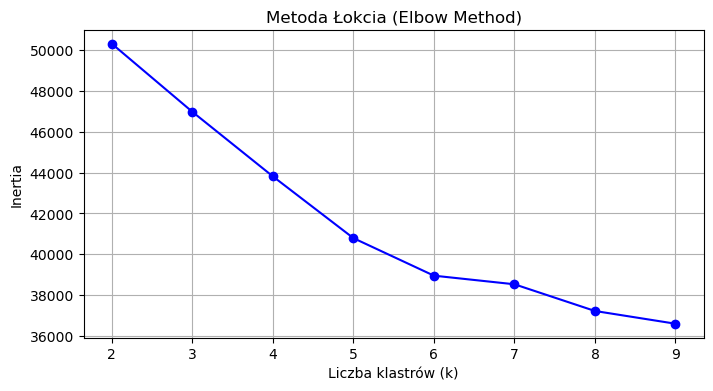


Silhouette Score dla k=2: 0.0728


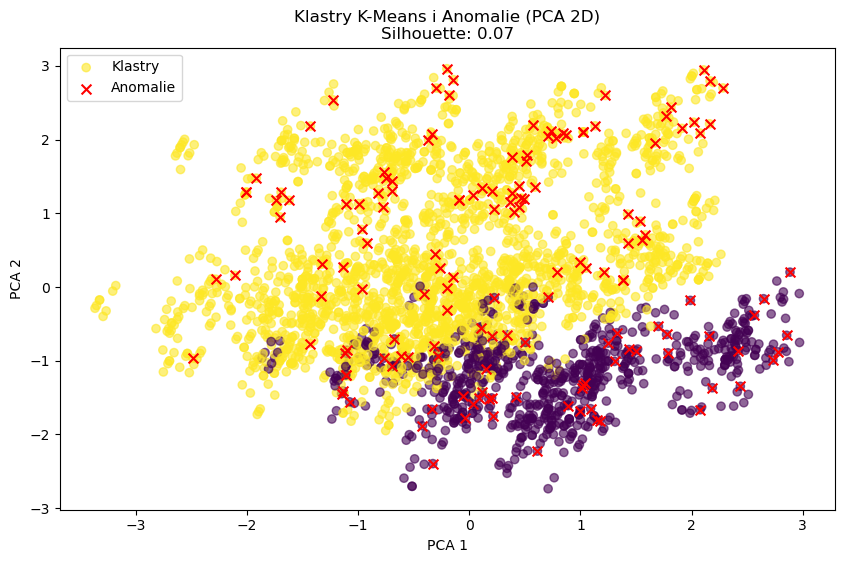

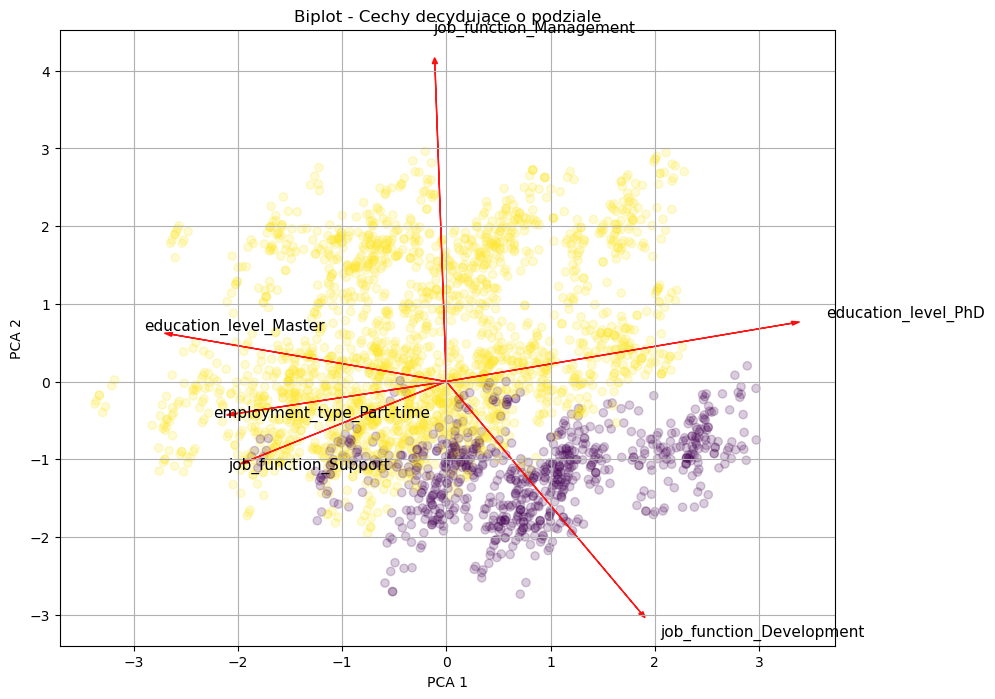

In [24]:
# ==========================================
# ZADANIE 17: KLASTRYZACJA I ANOMALIE
# ==========================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.ensemble import IsolationForest

# 1. Przygotowanie danych (korzystamy z wczytanego wcześniej df)
# Wybieramy cechy, które nadają się do grupowania (kategorie + binarne)
features_clustering = [
    'telecommuting', 
    'has_logo', 
    'employment_type', 
    'required_experience_years', 
    'education_level', 
    'industry', 
    'job_function'
]

# Kopiujemy dane i wypełniamy braki
X_cluster = df[features_clustering].fillna('Unknown').copy()

# Prawdziwe etykiety (do sprawdzenia jakości, ale nie używamy ich w uczeniu!)
# Zamieniamy 'Status:Fake' / 'Status:Real' na 1 i 0, lub używamy oryginalnej kolumny
if df['is_fake'].dtype == 'object':
    y_true = df['is_fake'].apply(lambda x: 1 if 'Fake' in str(x) else 0)
else:
    y_true = df['is_fake']

# 2. Zamiana na liczby (One-Hot Encoding)
X_encoded = pd.get_dummies(X_cluster, drop_first=True)

# 3. Skalowanie (Kluczowe dla K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

print(f"Dane przygotowane do klastryzacji. Wymiary: {X_scaled.shape}")

# --- PODPUNKT A: Metoda Łokcia i Analiza Klastrów ---

inertia = []
k_values = range(2, 10)

# Funkcja pomocnicza do purity
def purity_score(y_true, y_pred):
    contingency_matrix = confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

print(f"\n{'k':<5} {'Inertia':<15} {'Purity (Zgodność z etykietami)':<30}")
print("-" * 60)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    
    purity = purity_score(y_true, labels)
    print(f"{k:<5} {kmeans.inertia_:<15.2f} {purity:<10.4f}")

# Wykres Elbow
plt.figure(figsize=(8, 4))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Inertia')
plt.title('Metoda Łokcia (Elbow Method)')
plt.grid(True)
plt.show()

# --- PODPUNKT B: PCA i Wizualizacja (Anomalie) ---

# Zakładamy optymalne k=2 (bo mamy Real vs Fake)
optimal_k = 2 
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

# Redukcja do 2D za pomocą PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Obliczenie Silhouette Score (jakość klastrów)
sil_score = silhouette_score(X_scaled, clusters)
print(f"\nSilhouette Score dla k={optimal_k}: {sil_score:.4f}")

# Wykrywanie Anomalii (Isolation Forest)
iso = IsolationForest(contamination=0.05, random_state=42) # zakladamy 5% anomalii
anomalies = iso.fit_predict(X_scaled) # -1 to anomalia, 1 to norma

# Wizualizacja PCA
plt.figure(figsize=(10, 6))
# Rysujemy punkty, kolorujemy wg klastrów z K-Means
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6, label='Klastry')
# Oznaczamy anomalie czerwonymi krzyżykami
anomalies_idx = np.where(anomalies == -1)
plt.scatter(X_pca[anomalies_idx, 0], X_pca[anomalies_idx, 1], c='red', marker='x', s=50, label='Anomalie')

plt.title(f'Klastry K-Means i Anomalie (PCA 2D)\nSilhouette: {sil_score:.2f}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

# --- PODPUNKT C: Biplot (Co wpływa na klastry?) ---

# Pobieramy wagi (loadings) z PCA
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
features = X_encoded.columns

# Rysujemy uproszczony biplot (Top 6 cech)
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.2)

# Znajdujemy cechy o najdłuższych wektorach
magnitudes = np.linalg.norm(loadings, axis=1)
top_indices = np.argsort(magnitudes)[-6:] # Top 6 najważniejszych cech

for i in top_indices:
    plt.arrow(0, 0, loadings[i, 0]*5, loadings[i, 1]*5, color='r', alpha=0.9, head_width=0.05)
    plt.text(loadings[i, 0]*5.5, loadings[i, 1]*5.5, features[i], color='black', fontsize=11)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Biplot - Cechy decydujące o podziale")
plt.grid()
plt.show()

--- 1. Wczytywanie i przygotowanie danych ---
Dane gotowe. Wymiary: (8000, 7)
Etykiety zakodowane jako: ['High', 'Low', 'Medium']

--- Zadanie 17a: Szukanie optymalnego k i anomalii ---
Wykryto 400 anomalii.
k     Inertia         Purity    
-----------------------------------
2     49934.49        0.5881    
3     46211.88        0.5881    
4     43146.94        0.5881    
5     40914.74        0.5881    
6     38928.39        0.5881    
7     37174.63        0.5881    
8     35778.48        0.5881    
9     34544.50        0.5881    
10    33347.39        0.5881    
11    32430.70        0.5881    
12    31383.33        0.5881    
13    30459.13        0.5881    
14    29667.53        0.5881    


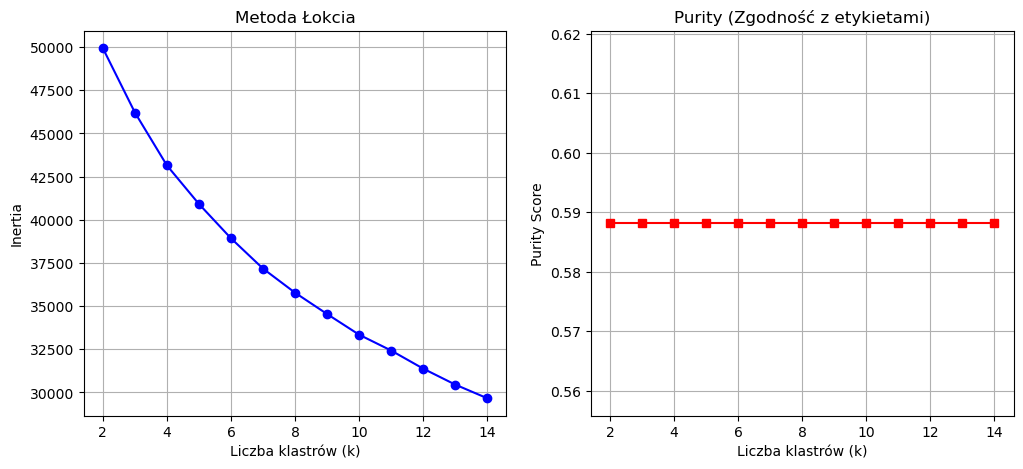


--- Zadanie 17b: Klastryzacja z PCA ---
Silhouette Score (Pełne dane): 0.0952
Silhouette Score (PCA 2D):     0.3394

--- Zadanie 17c: Wizualizacja Biplot ---


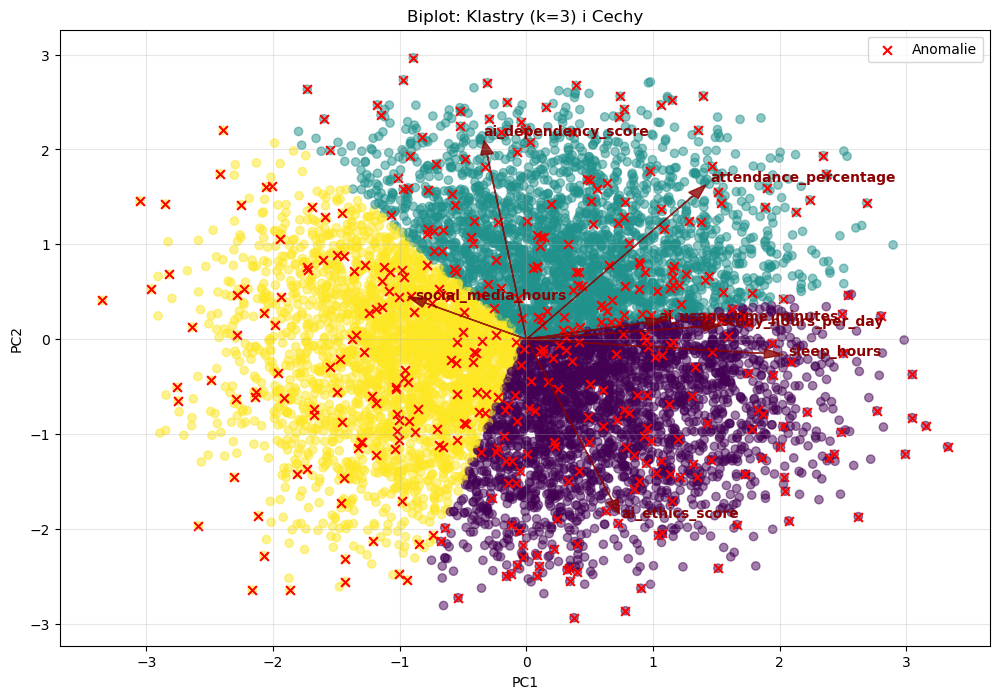

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.ensemble import IsolationForest

# ==========================================
# 1. PRZYGOTOWANIE DANYCH
# ==========================================
print("--- 1. Wczytywanie i przygotowanie danych ---")

# Wczytanie danych
filename = 'AIUsage/ai_impact_student_performance_dataset.csv'
df = pd.read_csv(filename)

features = [
    'study_hours_per_day', 
    'ai_usage_time_minutes', 
    'ai_dependency_score', 
    'ai_ethics_score', 
    'attendance_percentage', 
    'sleep_hours', 
    'social_media_hours'
]

# Sprawdzamy, które kolumny faktycznie istnieją
available_features = [col for col in features if col in df.columns]
X = df[available_features].fillna(df[available_features].mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

if 'performance_category' in df.columns:
    y_raw = df['performance_category'].astype(str)
else:
    y_raw = pd.cut(df['final_score'], bins=[-1, 60, 85, 100], labels=['Low', 'Medium', 'High']).astype(str)

# Zamieniamy teksty ("High", "Low") na liczby (0, 1, 2), żeby pasowały do K-Means
le = LabelEncoder()
y_true = le.fit_transform(y_raw) 

print(f"Dane gotowe. Wymiary: {X_scaled.shape}")
print(f"Etykiety zakodowane jako: {list(le.classes_)}")


# ==========================================
# ZADANIE 17a: K-Means, Elbow Method, Purity
# ==========================================
print("\n--- Zadanie 17a: Szukanie optymalnego k i anomalii ---")

inertia = []
purity_scores = []
k_values = range(2, 15)

# Funkcja do obliczania Purity
def calculate_purity(y_true, y_pred):
    # Teraz oba wejścia są liczbami, więc confusion_matrix zadziała
    cm = confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)

# Wykrywanie anomalii
iso = IsolationForest(contamination=0.05, random_state=42)
anomalies = iso.fit_predict(X_scaled)
df['is_anomaly'] = anomalies
num_anomalies = (anomalies == -1).sum()

print(f"Wykryto {num_anomalies} anomalii.")
print(f"{'k':<5} {'Inertia':<15} {'Purity':<10}")
print("-" * 35)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertia.append(kmeans.inertia_)
    purity = calculate_purity(y_true, labels)
    purity_scores.append(purity)
    
    print(f"{k:<5} {kmeans.inertia_:<15.2f} {purity:<10.4f}")

# Wykresy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Inertia')
plt.title('Metoda Łokcia')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, purity_scores, 'rs-')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Purity Score')
plt.title('Purity (Zgodność z etykietami)')
plt.grid(True)
plt.show()

# ==========================================
# ZADANIE 17b: Porównanie Oryginał vs PCA
# ==========================================
print("\n--- Zadanie 17b: Klastryzacja z PCA ---")

optimal_k = 3 # Zakładamy 3 grupy (Słabi, Średni, Dobrzy)

# 1. K-Means na pełnych danych
kmeans_full = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_full = kmeans_full.fit_predict(X_scaled)
sil_full = silhouette_score(X_scaled, labels_full)

# 2. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3. K-Means na PCA
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_pca = kmeans_pca.fit_predict(X_pca)
sil_pca = silhouette_score(X_pca, labels_pca)

print(f"Silhouette Score (Pełne dane): {sil_full:.4f}")
print(f"Silhouette Score (PCA 2D):     {sil_pca:.4f}")

# ==========================================
# ZADANIE 17c: Biplot
# ==========================================
print("\n--- Zadanie 17c: Wizualizacja Biplot ---")

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pca, cmap='viridis', alpha=0.5)

# Anomalie
anomalies_idx = df[df['is_anomaly'] == -1].index
plt.scatter(X_pca[anomalies_idx, 0], X_pca[anomalies_idx, 1], c='red', marker='x', s=40, label='Anomalie')

# Wektory cech
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
scaling_factor = 3

for i, feature in enumerate(available_features):
    x_end = loadings[i, 0] * scaling_factor
    y_end = loadings[i, 1] * scaling_factor
    plt.arrow(0, 0, x_end, y_end, color='darkred', alpha=0.8, head_width=0.1)
    plt.text(x_end * 1.1, y_end * 1.1, feature, color='darkred', fontsize=10, weight='bold')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Biplot: Klastry (k={optimal_k}) i Cechy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Generowanie Mapy Ciepła z Dendrogramem...


/home/bartek/anaconda3/envs/kombi/lib/python3.11/site-packages/seaborn/matrix.py:495: DeprecationWarning:

`product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.

/home/bartek/anaconda3/envs/kombi/lib/python3.11/site-packages/seaborn/matrix.py:495: DeprecationWarning:

`product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.



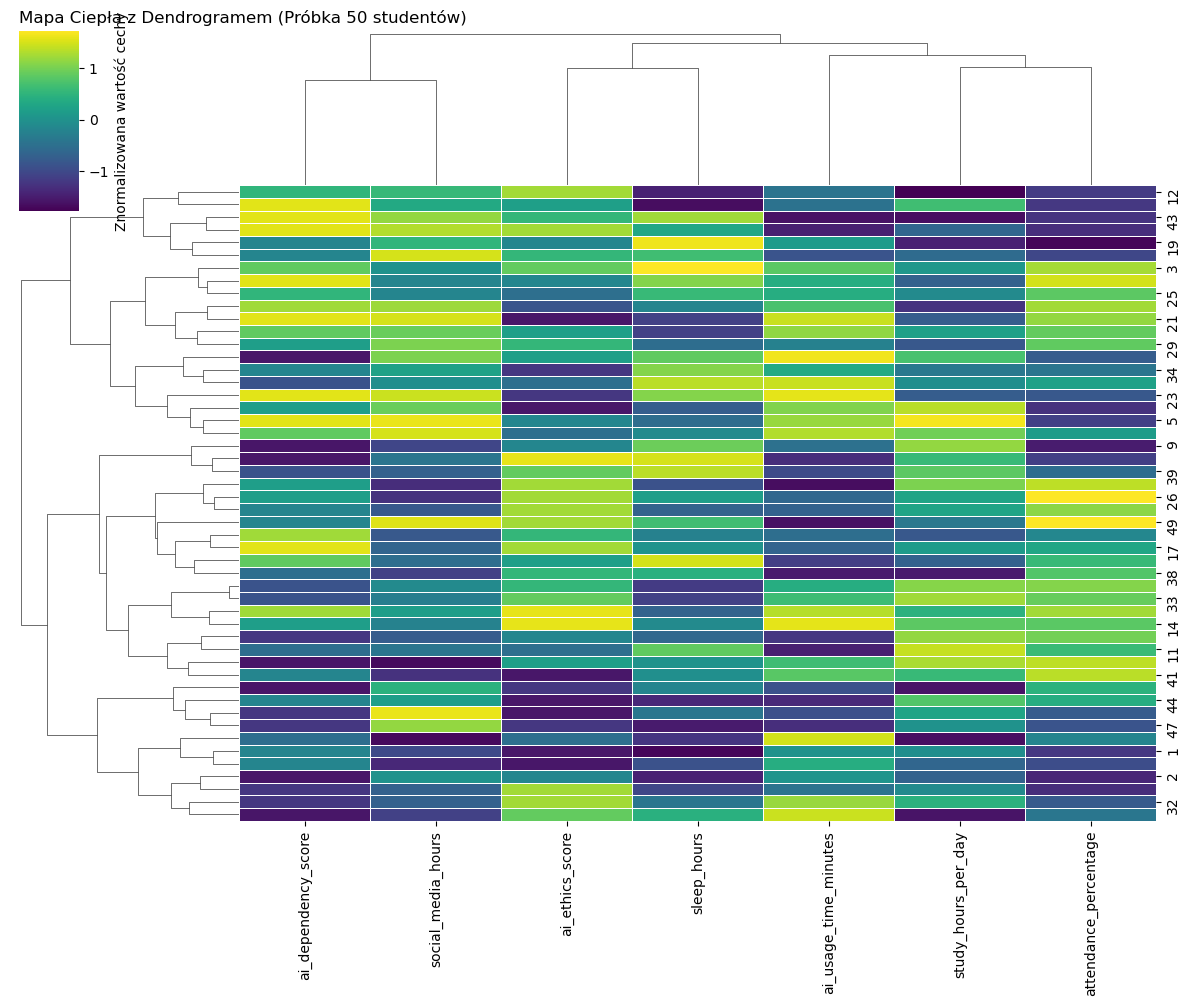

In [39]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# ZADANIE 17c: Mapa Ciepła z Dendrogramem (Clustermap)
# ==========================================

print("Generowanie Mapy Ciepła z Dendrogramem...")

# 1. Pobieramy próbkę danych 
sample_size = 50
sample_idx = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_idx]

# 2. Tworzymy DataFrame, żeby mieć nazwy kolumn na wykresie
df_plot = pd.DataFrame(X_sample, columns=available_features)

# 3. Rysujemy Clustermap
# method='ward': metoda łączenia klastrów (ta sama co w standardowym k-means/hierarchicznym)
# metric='euclidean': odległość euklidesowa
# standard_scale=1: normalizuje kolumny (cechy) do zakresu 0-1 dla lepszych kolorów, 
# choć X_scaled jest już przeskalowany, to tu poprawia kontrast wizualny.
g = sns.clustermap(
    df_plot,
    method='ward',
    metric='euclidean',
    cmap='viridis',        # Paleta kolorów (fioletowy=nisko, żółty=wysoko)
    figsize=(12, 10),      # Rozmiar
    dendrogram_ratio=0.2,  # Ile miejsca zajmuje drzewko
    linewidths=0.5,        # Linie między kratkami
    cbar_kws={'label': 'Znormalizowana wartość cechy'}
)

plt.title(f"Mapa Ciepła z Dendrogramem (Próbka {sample_size} studentów)", loc='left')
plt.show()